In [16]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import numpy.typing as npt
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf
import tensorflow_datasets as tfds

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#append path with python modules
import importlib

from dataclasses import dataclass
from modules import metropolis as metro
importlib.reload(metro)
from modules import qft_problem
importlib.reload(qft_problem)
from modules.hamiltonians import hamiltonian_terms
importlib.reload(hamiltonian_terms)
import modules.ansatz_nn as ansatz_nn
importlib.reload(ansatz_nn)
import modules.hamiltonians.lieb_liniger_model as ll_model
importlib.reload(ll_model)
import modules.plots as plots
importlib.reload(plots);


# Data generation



We have some many-body system with the Hamiltonian $H$ and we want to find its ground state. We use variational principle to find the ground energy of the system. Given the n particle positions $x_n$ the neural network calculate the $\varphi_n(x_n)$ wave function amplitude for given configuration.



To estimate the ground state energy we use monte carlo integration techinique, with sampling the configurations according to our current neural network model.
To do that we use metropolis algorithm. This means that our data generation is coupled to the current model.

As to demonstrate the data generation we create a test problem in 2d, with wave function that is exponentially decaying with number of particles times $(n + 0.1)$ times the product of sinuses in first and second dimension. We then create the dataset from generator that uses metropolis algorithm to create next steps on our test model. We see the distribution of configurations is the estimation of the test problem.

In [2]:
@dataclass
class TestProblem(qft_problem.QFTProblem):
    size: tuple[float, float] = (10, 100)

    def volume(self) -> npt.NDArray:
        return np.array(self.size)

    def get_amplitude(self, x_n: tf.Tensor, ns: npt.NDArray, training: bool = False) -> tf.Tensor:
        mask = tf.sequence_mask(ns, maxlen = x_n.shape[-2])

        mask = tf.cast(mask, x_n.dtype)
        masked_sin = tf.where(mask > 0, tf.sin(x_n[:, :, 0]) * tf.sin(x_n[:, :, 1] / 20), tf.ones_like(x_n[:, :, 0])) # type: ignore
        profile = tf.pow(tf.reduce_prod(masked_sin, axis=1), 2)

        ns = tf.cast(ns, x_n.dtype) # type: ignore

        return profile * np.exp(-ns / 10.) / np.power(np.prod(self.volume()), ns / 2.) * (0.1 + ns)

In [3]:
batch = 1
n_max = 10

test_problem = TestProblem()
test_metropolis = metro.FockSpaceMetropolis(test_problem, n_max, rng=np.random.default_rng(0))

def metropolis_step(metropolis: metro.FockSpaceMetropolis, batch = 32, n_init = 5):
    x_recent, amplitude_recent = metropolis.new_configuration(batch, n_init)
    while True:
        x_recent, amplitude_recent = metropolis.step(x_recent, amplitude_recent)
        yield x_recent.x_n, x_recent.n_s

dataset = tf.data.Dataset.from_generator(
    lambda: metropolis_step(test_metropolis, batch = batch),
    output_signature = (
        tf.TensorSpec(shape=(batch, n_max, 2), dtype=tf.float32, name="configuration"), # type: ignore
        tf.TensorSpec(shape=(batch), dtype=tf.int32, name = "particle_no") # type: ignore
    )
)


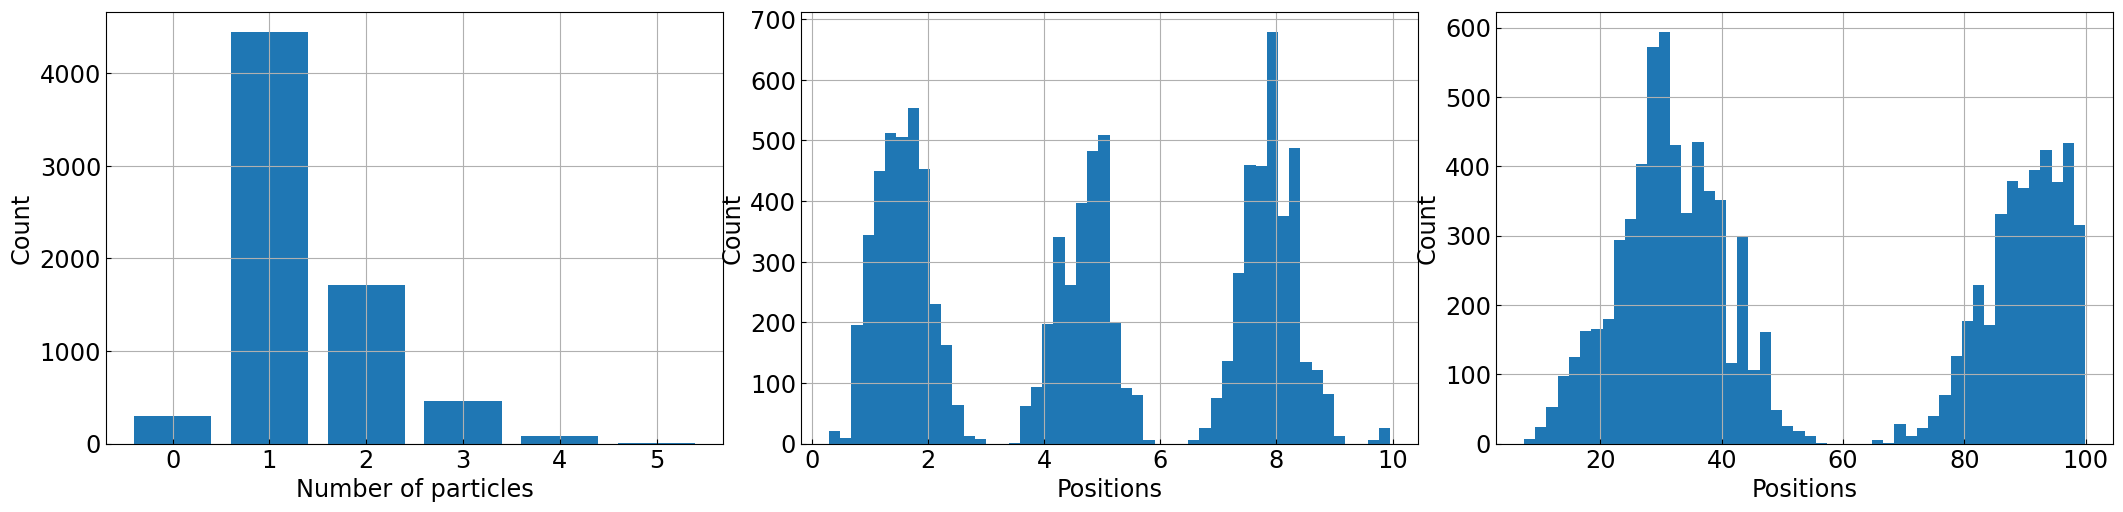

In [4]:
fig, axes = plots.plot_metropolis_samples(dataset.unbatch().skip(3000).take(7000), dim = 2);

In [5]:
tfds.benchmark(dataset.take(1000), batch_size = 32)


************ Summary ************



0it [00:00, ?it/s]

Examples/sec (First included) 27320.22 ex/sec (total: 32032 ex, 1.17 sec)
Examples/sec (First only) 1144.66 ex/sec (total: 32 ex, 0.03 sec)
Examples/sec (First excluded) 27959.59 ex/sec (total: 32000 ex, 1.14 sec)


,duration,num_examples,avg
first+lasts,1.172465,32032,27320.223174
first,0.027956,32,1144.659982
lasts,1.144509,32000,27959.590354


# Model architecture and learning

In our problem, we train the neural network using training data generated by the Metropolis algorithm from the given system configuration. To perform training, we must generate new training data separately for each training session. This is necessary because the training process involves minimizing the energy of the system, and the Metropolis algorithm generates a set of sample points $ x_n $ that are distributed according to the probability distribution corresponding to the current state of the system.

In the Deep Sets architecture that we use to represent the state of the system, we do not implement the network as a traditional sequence of connected layers. Instead, we define several models and compose their outputs.

The state of the system is represented as

$$|\Psi\rangle = \bigoplus_{n=0}^{\infty} \varphi_n(x_n),$$

where each $ \varphi_n $ is a symmetric function that takes $ n $ positions as its arguments. This structure suggests that the neural network, interpreted as a (wave)function $f : \mathbb{R}^N \rightarrow \mathbb{C} $, should have an architecture reflecting the decomposition

$$f(x_N) = \rho_1 \left( \sum_{x \in x_N} \phi_1(x) \right) \cdot \rho_2 \left( \sum_{x_i < x_j \in x_N} \phi_2(x_i - x_j) \right),$$

where $ N $ is a cutoff on the number of particles considered, and $ \rho_1 $, $ \rho_2 $ and $ \phi_1 $, $ \phi_2 $ are usual DNN.


# Lieb-Liniger theory

Lieb-Liniger theory is quantum field theory used in the theory of cold gases. It represents contact interactions (via δ-function), so it is analogous to more familiar ϕ^4 theory. The Hamiltonian of that theory is:

\begin{equation}
H_{\text{LL}} = \frac{1}{2m} \int dx \, \frac{d \hat{\psi}^\dagger(x)}{dx} \frac{d \hat{\psi}(x)}{dx}
- \mu \int dx \, \hat{\psi}^\dagger(x) \hat{\psi}(x)
+ g \int dx \, \hat{\psi}^\dagger(x) \hat{\psi}^\dagger(x) \hat{\psi}(x) \hat{\psi}(x).
\end{equation}

We have included the chemical potential in the Hamiltonian.
The contact interaction between particles is not implemented through an additional term in the energy (loss) function of the model, due to the difficulty of approximating such a singular object.
Instead, we multiply the output of the network by a so-called Jastrow factor (as also done by the authors of the cited paper):


\begin{equation}
J_n^{\text{LL}}(\mathbf{x}_n) = \prod_{i < j}^{n} \left( \frac{1}{L} |x_i - x_j| + \frac{1}{mgL} \right).
\end{equation}

This prescription ensures that the wavefunction vanishes when two or more particles coincide.
At the end of each neural network evaluation, we also multiply the output by a regularization factor that constrains the number of particles to lie within a finite window.
The parameters controlling the width of this window are also trainable. Regularisation factor takes the form:

\begin{equation}
\left( \frac{1}{1 + e^{-\alpha(n - q_1)}} \right) \left( \frac{1}{1 + e^{\alpha(n - q_2)}} \right)
\end{equation}

In case of "hard wall" boundary conditions, output of the network is also multiplied by a "cutoff factor" that imposes them:

\begin{equation}
\left( \frac{L}{30} \right)^{-n/2} \prod_{i=1}^{n} \frac{x_i}{L} \left( 1 - \frac{x_i}{L} \right),
\end{equation}


## Lieb-Liniger, with $m = 0.5$, $\mu = (3.75 \pi)^2$, $g = 10^6$

In [53]:
from modules.ansatz_nn import ParticleNoReg

input_dim = 1
batch_size = 64

ds1 = ansatz_nn.DeepSets(64, 2, 2, input_dim=input_dim, name = "deep_set_1")
ds2 = ansatz_nn.DeepSets(64, 2, 2, input_dim=input_dim, name = "deep_set_2")

hamiltonian = ll_model.LiebLinigerHamiltonian(0.5, (3.75 * np.pi) ** 2, 1e6)

test_model = ansatz_nn.QFTNeuralNet(
    np.array([1]),
    ds1,
    ds2,
    hamiltonian,
    is_periodic = False,
    regularization = ParticleNoReg(5., 0.3, 0.3),
)

dataset = metro.make_dataset(test_model, batch_size, 10, 5)

In [54]:
tfds.benchmark(dataset.take(1000), batch_size = batch_size)


************ Summary ************



0it [00:00, ?it/s]

Examples/sec (First included) 4760.08 ex/sec (total: 64064 ex, 13.46 sec)
Examples/sec (First only) 686.96 ex/sec (total: 64 ex, 0.09 sec)
Examples/sec (First excluded) 4788.47 ex/sec (total: 64000 ex, 13.37 sec)


,duration,num_examples,avg
first+lasts,13.458601,64064,4760.078774
first,0.093163,64,686.964315
lasts,13.365437,64000,4788.470333


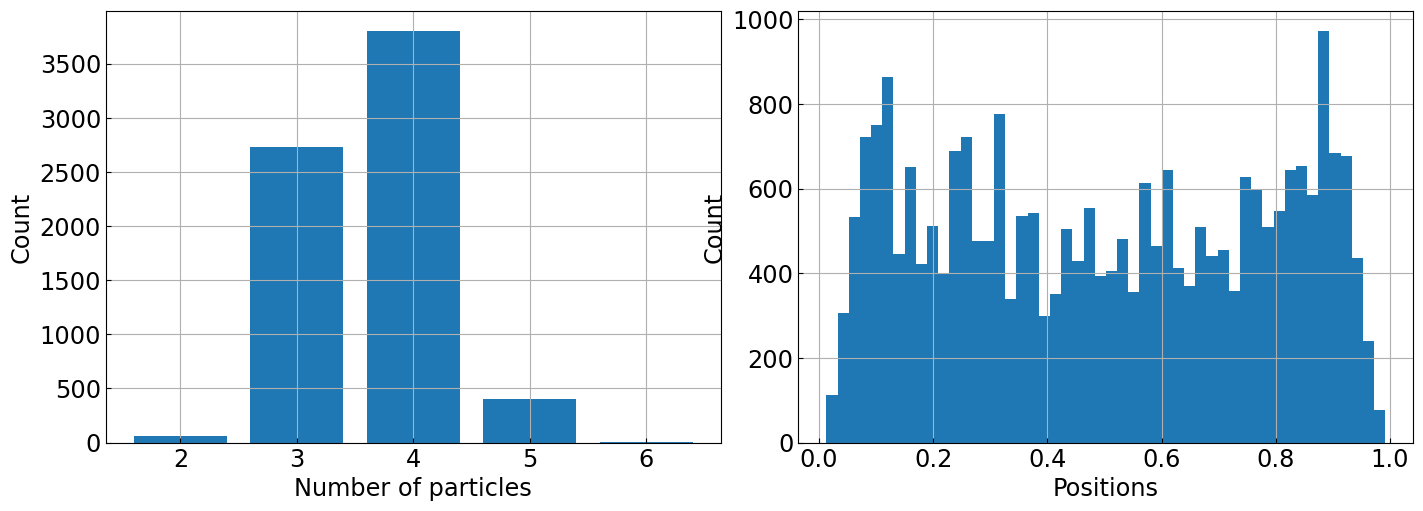

In [55]:
fig, axes = plots.plot_metropolis_samples(dataset.skip(500).unbatch().take(7000));

In [36]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-3,
    decay_steps = 25,
    decay_rate = 0.9,
    staircase=True
)

test_model.compile(
    optimizer = tf.keras.optimizers.Adam(lr_schedule),
    regularization_lr_modifier = 1
)

history = test_model.fit(
    dataset.skip(500).take(1000),
    epochs = 200,
)

Epoch 1/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - energy: -180.8209 - loss: -180.8209 - mean_particle_number: 3.5773
Epoch 2/200


c:\Users\marcr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -245.5231 - loss: -245.5231 - mean_particle_number: 3.5579
Epoch 3/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -251.8494 - loss: -251.8494 - mean_particle_number: 3.5226
Epoch 4/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: 1265.6952 - loss: 1265.6952 - mean_particle_number: 3.4668
Epoch 5/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -233.4861 - loss: -233.4861 - mean_particle_number: 3.4499
Epoch 6/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - energy: -218.0250 - loss: -218.0250 - mean_particle_number: 3.4532
Epoch 7/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -258.8304 - loss: -258.8304 - mean_particle_number: 3.4324
Epoch 8/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -209.5412 - loss: -209.5412 - mean_particle_number: 3.4463
Epoch 9/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -240.3411 - loss: -240.3411 - mean_particle_number: 3.4182
Epoc

KeyboardInterrupt: 

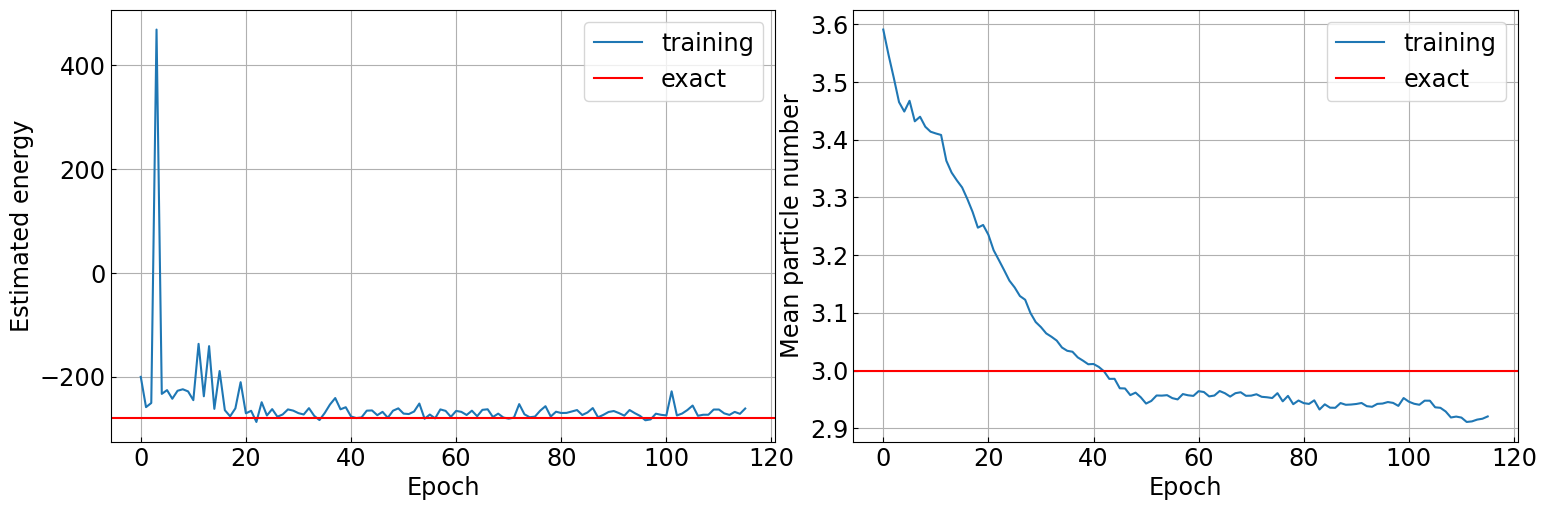

In [37]:
fig, axes = plots.plot_train_history(test_model.history, -278.2, 3)

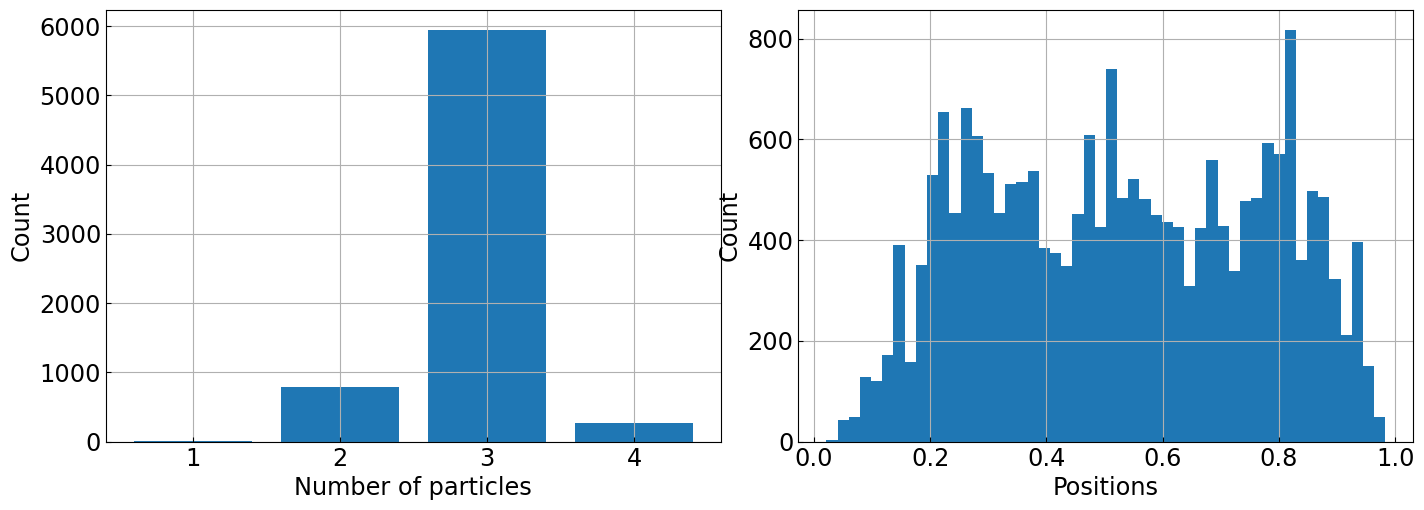

In [38]:
fig, axes = plots.plot_metropolis_samples(dataset.skip(500).unbatch().take(7000));

We tried other Lieb-Linigier parameters, however for other parameters learning is very unstable, same with Calogero Sutherland model.
Probably it needs more fine tunings such as embeddings, more stable kinetic terms, larger networks and smaller learning rates which would make learning really long.
(Or there is bug somewhere in the code still :()
